# Análise de Feriados e Clima no Rio de Janeiro - 2024

In [85]:
import requests
from datetime import datetime
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calmap

# Configurações de estilo para os gráficos
plt.style.use('seaborn-v0_8-dark')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

In [86]:
# Função para obter feriados do Brasil em 2024
def get_holidays_2024():
    url = "https://date.nager.at/api/v3/PublicHolidays/2024/BR"
    response = requests.get(url)
    return response.json()

# Função para obter dados climáticos do Rio de Janeiro
def get_weather_data(start_date, end_date):
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude=-22.9068&longitude=-43.1729&start_date={start_date}&end_date={end_date}&daily=temperature_2m_mean,weathercode&timezone=America%2FSao_Paulo"
    response = requests.get(url)
    return response.json()

# Obter dados
holidays_2024 = get_holidays_2024()
weather_data = get_weather_data("2024-01-01", "2024-08-01")

## 1. Quantos feriados há no Brasil em todo o ano de 2024?

Total de feriados em 2024: 14


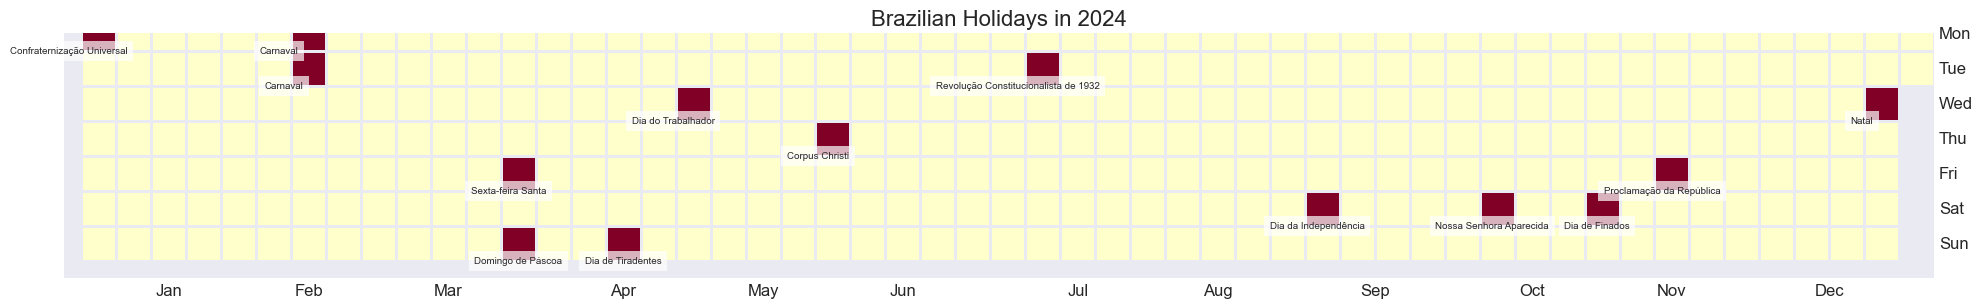

In [60]:
total_holidays = len(holidays_2024)
print(f"Total de feriados em 2024: {total_holidays}")

df = pd.DataFrame(holidays_2024)
df['date'] = pd.to_datetime(df['date'])

df = pd.DataFrame(holidays_2024)
df['date'] = pd.to_datetime(df['date'])

# 1 para feriados e 0 para dias normais
start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)
date_range = pd.date_range(start, end)
holidays_series = pd.Series(0, index=date_range)
holidays_series[df['date']] = 1

# heatmap
fig, ax = plt.subplots(figsize=(20, 12))
calmap.yearplot(holidays_series, year=2024, cmap='YlOrRd', fillcolor='lightgrey', linewidth=1, ax=ax)
ax.set_ylim(-0.5, 6.5) 
ax.set_xlim(-0.5, 53) 


plt.title('Brazilian Holidays in 2024', fontsize=16)

# Adiciona os nomes dos feriados
for _, holiday in df.iterrows():
  date = holiday['date']
  name = holiday['localName']
  
  x = date.dayofyear / 7 - 0.5 
  y = 6 - date.weekday() 
  
  ax.text(x, y, name, 
          ha='center', va='center', rotation=0, fontsize=7,
          bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.subplots_adjust(bottom=0.1, top=0.95)
plt.tight_layout()
plt.show()

## 2. Qual mês de 2024 tem o maior número de feriados?

Meses com mais feriados (2 feriados cada):
- Fevereiro
- Março
- Maio
- Novembro


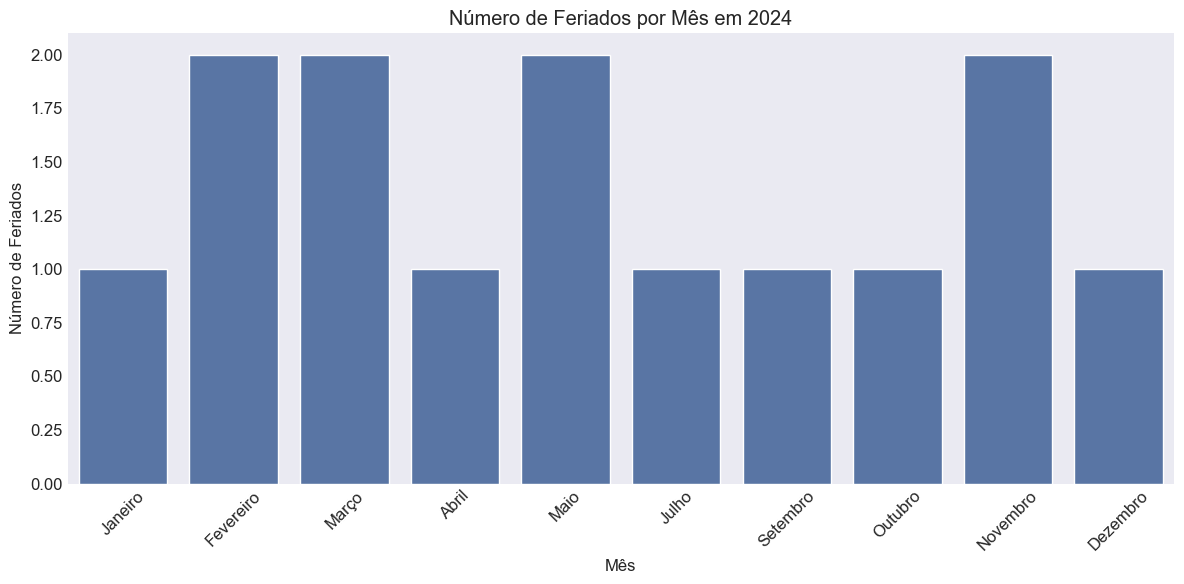

In [61]:
holidays_by_month = {}
for holiday in holidays_2024:
    month = datetime.strptime(holiday['date'], "%Y-%m-%d").month
    holidays_by_month[month] = holidays_by_month.get(month, 0) + 1

# Encontrar o número máximo de feriados
max_holidays = max(holidays_by_month.values())

# Encontrar todos os meses com o número máximo de feriados
months_with_most_holidays = [month for month, count in holidays_by_month.items() if count == max_holidays]

# Converter números dos meses para nomes
month_names = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
               7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

print(f"Meses com mais feriados ({max_holidays} feriados cada):")
for month in months_with_most_holidays:
    print(f"- {month_names[month]}")

# Visualização
plt.figure(figsize=(12, 6))
sns.barplot(x=[month_names[m] for m in holidays_by_month.keys()], y=list(holidays_by_month.values()))
plt.title('Número de Feriados por Mês em 2024')
plt.xlabel('Mês')
plt.ylabel('Número de Feriados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Quantos feriados em 2024 caem em dias de semana (segunda a sexta-feira)?

Feriados em dias de semana: 9
Feriados em fins de semana: 5


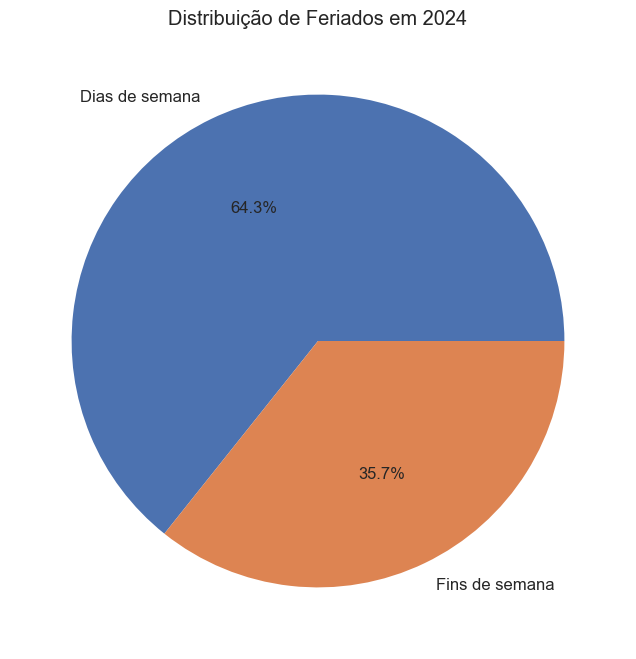

In [17]:
weekday_holidays = sum(1 for holiday in holidays_2024 if datetime.strptime(holiday['date'], "%Y-%m-%d").weekday() < 5)
weekend_holidays = total_holidays - weekday_holidays
print(f"Feriados em dias de semana: {weekday_holidays}")
print(f"Feriados em fins de semana: {weekend_holidays}")

# Visualização
plt.figure(figsize=(8, 8))
plt.pie([weekday_holidays, weekend_holidays], labels=['Dias de semana', 'Fins de semana'], autopct='%1.1f%%')
plt.title('Distribuição de Feriados em 2024')
plt.show()

## 4. Qual foi a temperatura média em cada mês?

Temperatura média por mês:
Mês 1: 26.70°C
Mês 2: 27.20°C
Mês 3: 26.42°C
Mês 4: 25.17°C
Mês 5: 24.99°C
Mês 6: 22.64°C
Mês 7: 21.11°C
Mês 8: 21.20°C


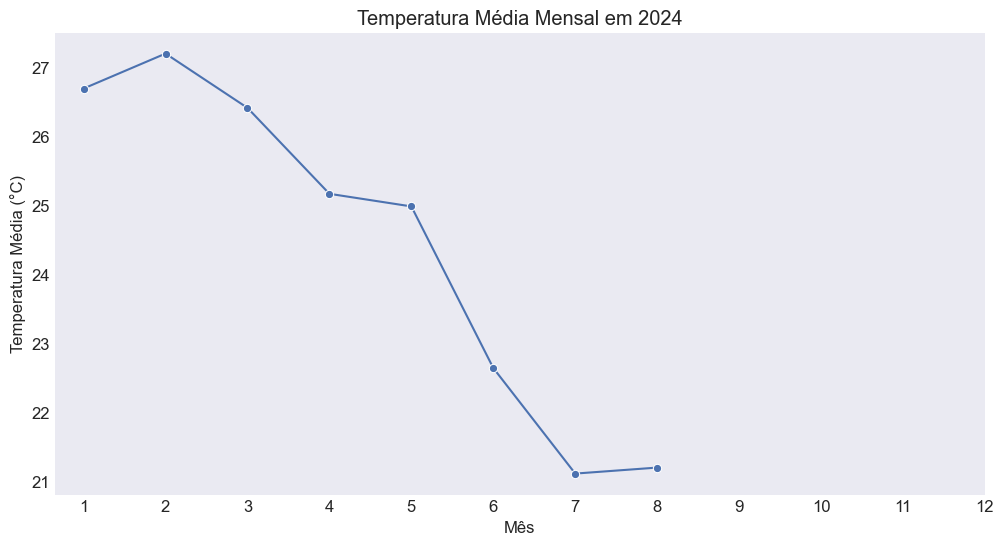

In [18]:
monthly_temps = {}
for date, temp in zip(weather_data['daily']['time'], weather_data['daily']['temperature_2m_mean']):
    month = datetime.strptime(date, "%Y-%m-%d").month
    if month not in monthly_temps:
        monthly_temps[month] = []
    monthly_temps[month].append(temp)

avg_monthly_temps = {month: sum(temps) / len(temps) for month, temps in monthly_temps.items()}
print("Temperatura média por mês:")
for month, temp in avg_monthly_temps.items():
    print(f"Mês {month}: {temp:.2f}°C")

# Visualização
plt.figure(figsize=(12, 6))
sns.lineplot(x=list(avg_monthly_temps.keys()), y=list(avg_monthly_temps.values()), marker='o')
plt.title('Temperatura Média Mensal em 2024')
plt.xlabel('Mês')
plt.ylabel('Temperatura Média (°C)')
plt.xticks(range(1, 13))
plt.show()

## 5. Qual foi o tempo predominante em cada mês nesse período?

Tempo predominante por mês:
Mês 1: Moderate rain
Mês 2: Light drizzle
Mês 3: Light drizzle
Mês 4: Overcast
Mês 5: Light drizzle
Mês 6: Mainly clear
Mês 7: Overcast
Mês 8: Partly cloudy


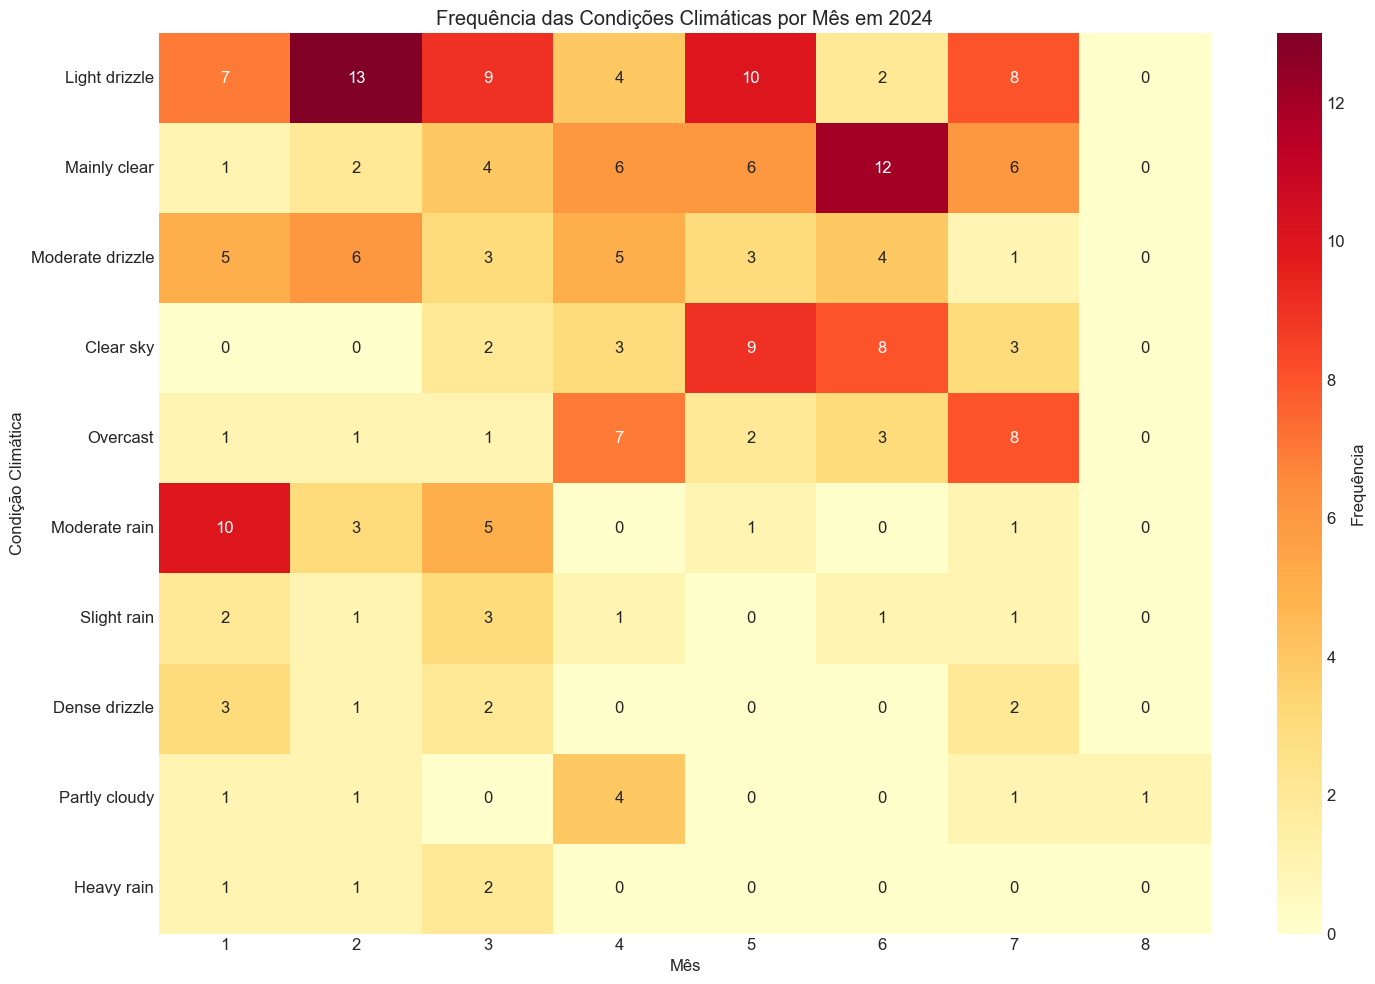

In [83]:
weather_codes = {
  0: "Clear sky", 1: "Mainly clear", 2: "Partly cloudy", 3: "Overcast",
  45: "Fog", 48: "Depositing rime fog", 51: "Light drizzle", 53: "Moderate drizzle",
  55: "Dense drizzle", 56: "Light freezing drizzle", 57: "Dense freezing drizzle",
  61: "Slight rain", 63: "Moderate rain", 65: "Heavy rain", 66: "Light freezing rain",
  67: "Heavy freezing rain", 71: "Slight snow fall", 73: "Moderate snow fall",
  75: "Heavy snow fall", 77: "Snow grains", 80: "Slight rain showers",
  81: "Moderate rain showers", 82: "Violent rain showers", 85: "Slight snow showers",
  86: "Heavy snow showers", 95: "Thunderstorm", 96: "Thunderstorm with slight hail",
  99: "Thunderstorm with heavy hail"
}

monthly_weather = {}
for date, code in zip(weather_data['daily']['time'], weather_data['daily']['weathercode']):
  month = datetime.strptime(date, "%Y-%m-%d").month
  if month not in monthly_weather:
      monthly_weather[month] = []
  monthly_weather[month].append(code)

# Criar um DataFrame para o heatmap
weather_data = []
for month, codes in monthly_weather.items():
  count = Counter(codes)
  for code, freq in count.items():
      weather_data.append([month, weather_codes[code], freq])

df = pd.DataFrame(weather_data, columns=['Month', 'Weather', 'Frequency'])
pivot_df = df.pivot(index='Weather', columns='Month', values='Frequency').fillna(0)

# Ordenar as condições climáticas pela frequência total
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values('Total', ascending=False).drop('Total', axis=1)

predominant_weather = {month: Counter(codes).most_common(1)[0][0] for month, codes in monthly_weather.items()}
print("Tempo predominante por mês:")
for month, code in predominant_weather.items():
    print(f"Mês {month}: {weather_codes[code]}")

# Visualização
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_df, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Frequência'})
plt.title('Frequência das Condições Climáticas por Mês em 2024')
plt.xlabel('Mês')
plt.ylabel('Condição Climática')
plt.tight_layout()
plt.show()

## 6. Qual foi o tempo e a temperatura média em cada feriado de 01/01/2024 a 01/08/2024?

Tempo e temperatura média em cada feriado:
Confraternização Universal: 24.90°C, Light drizzle
Carnaval: 30.50°C, Light drizzle
Sexta-feira Santa: 25.00°C, Slight rain
Domingo de Páscoa: 24.50°C, Moderate drizzle
Dia de Tiradentes: 23.10°C, Partly cloudy
Dia do Trabalhador: 28.10°C, Clear sky
Corpus Christi: 20.80°C, Light drizzle
Revolução Constitucionalista de 1932: 21.50°C, Moderate drizzle


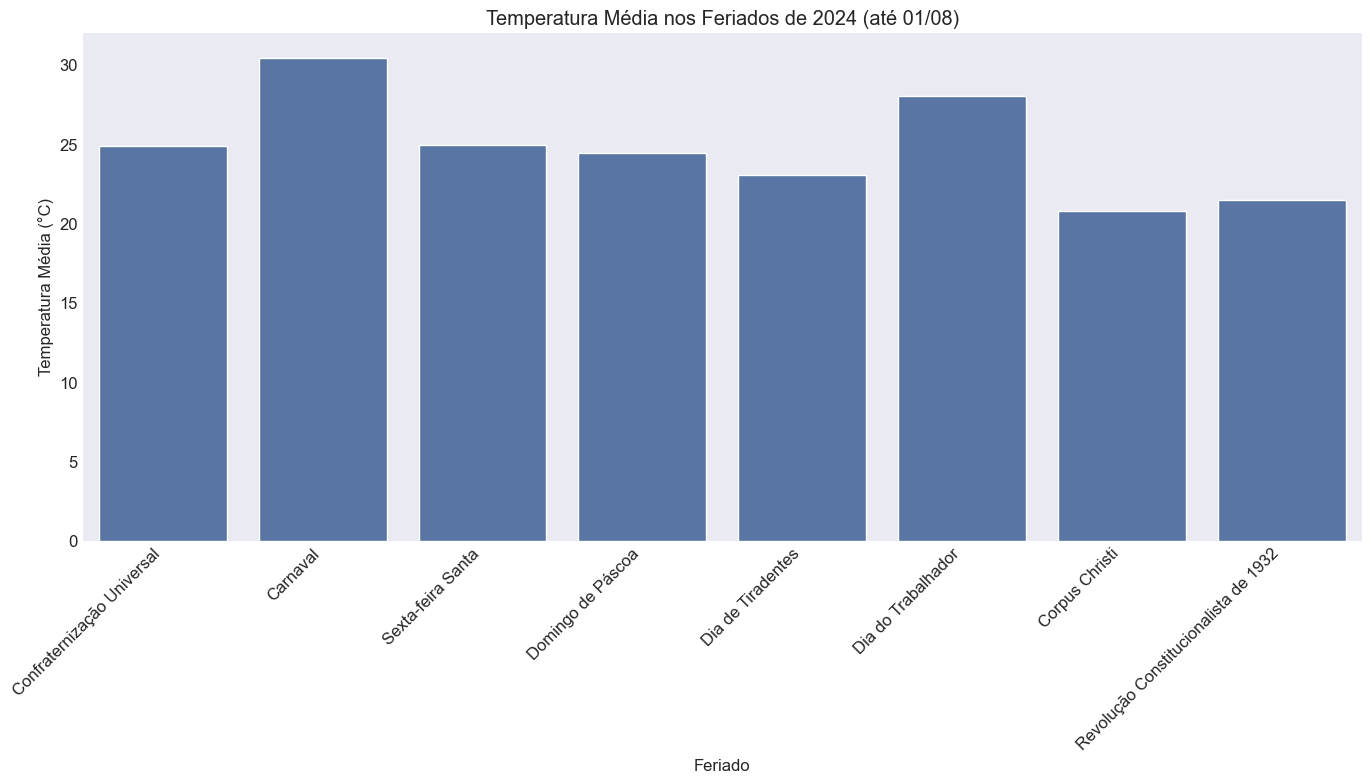

In [87]:
holiday_weather = {}
for holiday in holidays_2024:
    date = holiday['date']
    if date <= "2024-08-01":
        index = weather_data['daily']['time'].index(date)
        temp = weather_data['daily']['temperature_2m_mean'][index]
        code = weather_data['daily']['weathercode'][index]
        holiday_weather[holiday['localName']] = (temp, weather_codes[code])

print("Tempo e temperatura média em cada feriado:")
for holiday, (temp, weather) in holiday_weather.items():
    print(f"{holiday}: {temp:.2f}°C, {weather}")

# Visualização
plt.figure(figsize=(14, 8))
sns.barplot(x=list(holiday_weather.keys()), y=[temp for temp, _ in holiday_weather.values()])
plt.title('Temperatura Média nos Feriados de 2024 (até 01/08)')
plt.xlabel('Feriado')
plt.ylabel('Temperatura Média (°C)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7 e 8. Feriados "não aproveitáveis" e "mais aproveitável"

Feriados não aproveitáveis:
Confraternização Universal: 24.90°C
Carnaval: 30.50°C
Sexta-feira Santa: 25.00°C
Domingo de Páscoa: 24.50°C
Corpus Christi: 20.80°C
Revolução Constitucionalista de 1932: 21.50°C

Feriado mais aproveitável: Carnaval com temperatura de 30.20°C


C:\Users\migue\AppData\Local\Temp\ipykernel_13688\1332077308.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_names, y=temperatures, palette=colors)
C:\Users\migue\AppData\Local\Temp\ipykernel_13688\1332077308.py:37: UserWarning: The palette list has more values (9) than needed (8), which may not be intended.
  sns.barplot(x=holiday_names, y=temperatures, palette=colors)


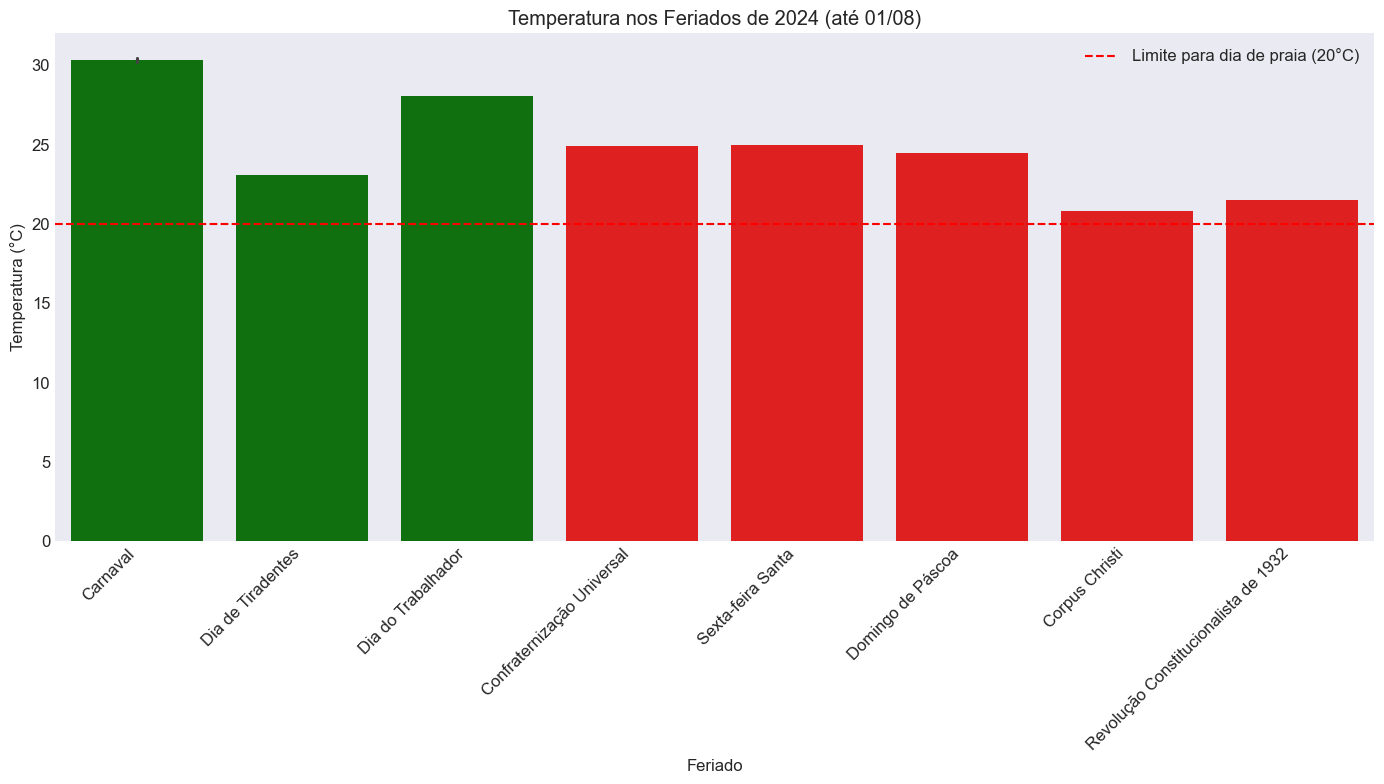

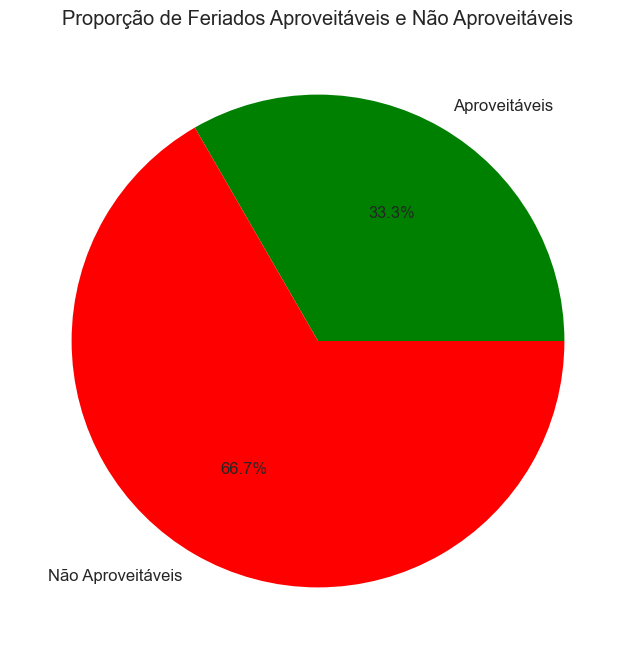

In [21]:
def is_beach_day(temp, weather_code):
    return temp >= 20 and weather_code < 3

non_beach_holidays = []
beach_holidays = []
best_holiday = None
best_temp = float('-inf')

for holiday in holidays_2024:
    date = holiday['date']
    if date <= "2024-08-01":
        index = weather_data['daily']['time'].index(date)
        temp = weather_data['daily']['temperature_2m_mean'][index]
        code = weather_data['daily']['weathercode'][index]
        
        if not is_beach_day(temp, code):
            non_beach_holidays.append((holiday['localName'], temp))
        else:
            beach_holidays.append((holiday['localName'], temp))
            if temp > best_temp:
                best_temp = temp
                best_holiday = holiday['localName']

print("Feriados não aproveitáveis:")
for holiday, temp in non_beach_holidays:
    print(f"{holiday}: {temp:.2f}°C")

print(f"\nFeriado mais aproveitável: {best_holiday} com temperatura de {best_temp:.2f}°C")

# Visualização
plt.figure(figsize=(14, 8))
all_holidays = beach_holidays + non_beach_holidays
holiday_names = [h[0] for h in all_holidays]
temperatures = [h[1] for h in all_holidays]
colors = ['green' if h in beach_holidays else 'red' for h in all_holidays]

sns.barplot(x=holiday_names, y=temperatures, palette=colors)
plt.title('Temperatura nos Feriados de 2024 (até 01/08)')
plt.xlabel('Feriado')
plt.ylabel('Temperatura (°C)')
plt.axhline(y=20, color='r', linestyle='--', label='Limite para dia de praia (20°C)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico de pizza para proporção de feriados aproveitáveis e não aproveitáveis
plt.figure(figsize=(8, 8))
plt.pie([len(beach_holidays), len(non_beach_holidays)], 
        labels=['Aproveitáveis', 'Não Aproveitáveis'], 
        autopct='%1.1f%%', 
        colors=['green', 'red'])
plt.title('Proporção de Feriados Aproveitáveis e Não Aproveitáveis')
plt.show()

## Conclusão

Nesta análise, exploramos os feriados brasileiros e as condições climáticas no Rio de Janeiro para o ano de 2024. Aqui estão os principais insights:

1. O Brasil tem um total de 14 feriados em 2024.
2. O mês com mais feriados são os meses Fevereiro, Março, Maio, Novembro, com 2 feriados.
3. 9 feriados caem em dias de semana (segunda a sexta-feira).
4. A temperatura média mensal no Rio de Janeiro varia de 21.11°C a 27.20°C.
5. O tempo predominante na maioria dos meses é Light drizzle.
6. Os feriados apresentam uma variedade de condições climáticas, com temperaturas médias variando de 20.80°C a 28.10°C.
7. 6 feriados são considerados "não aproveitáveis" para ir à praia, devido a temperaturas baixas ou condições climáticas desfavoráveis.
8. O feriado mais "aproveitável" é o Carnaval, com uma temperatura média de 30.20°C.

Esta análise pode ser útil para planejamento de atividades, turismo e gestão urbana no Rio de Janeiro durante o ano de 2024.